In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.lda import LDA
#from sklearn.qda import QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
# Load data
sm_df = pd.read_csv('./data/Smarket.csv')
sm_df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


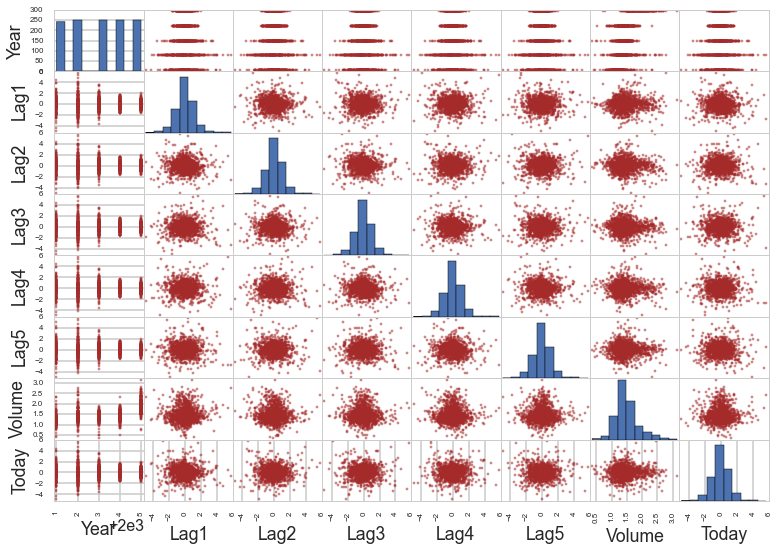

In [3]:
# scatter_matrix plot
ax = pd.tools.plotting.scatter_matrix(sm_df, color="brown")

In [4]:
# Compute pairwise correlation of columns, excluding NA/null values
# Excludes qualitative variables
sm_df.corr()
# Output shows that the only substantial correlation is between Year and Volume

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


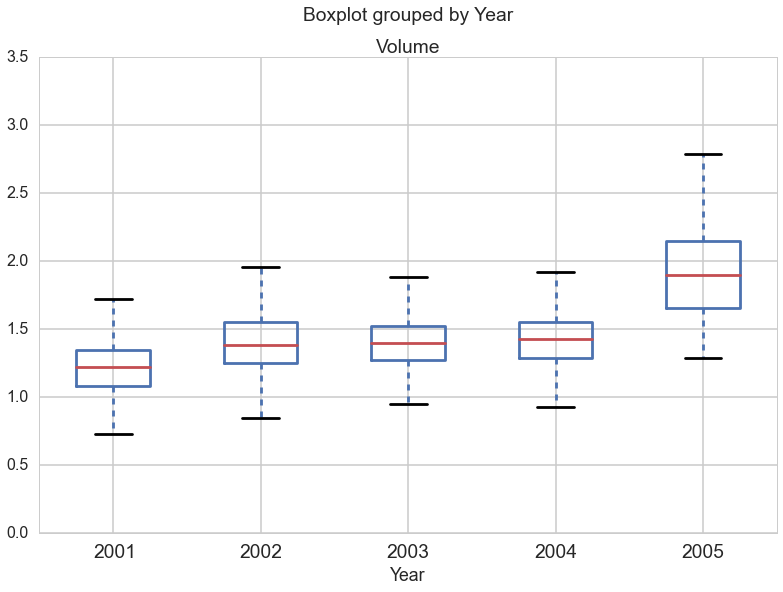

In [5]:
#plt.plot(sm_df["Year"],sm_df["Volume"])
sm_df.boxplot(column="Volume", by="Year")
# Volume is increasing over time

### Logistic Regression

In [6]:
X = sm_df.ix[:,1:-2]
y = pd.factorize(sm_df["Direction"])[0]
clf = LogisticRegression()
clf.fit(X,y)
print (clf.intercept_, clf.coef_)

[ 0.11454962] [[ 0.07279035  0.04229102 -0.010958   -0.00921799 -0.01023031 -0.12793931]]


In [7]:
# Print probability of each class
probs = clf.predict_proba(X)
print (probs)
# Print predicted class
print (clf.predict(X))

ypreds_num = clf.predict(X)

[[ 0.50775596  0.49224404]
 [ 0.48208765  0.51791235]
 [ 0.48147908  0.51852092]
 ..., 
 [ 0.53915342  0.46084658]
 [ 0.52629834  0.47370166]
 [ 0.51818546  0.48181454]]
[0 1 1 ..., 0 0 0]


In [8]:
ypreds = ["Up" if prob>.5 else "Down" for prob in probs[:,0]]
print (ypreds[0:5])

['Up', 'Down', 'Down', 'Up', 'Up']


In [9]:
# Confusion matrix
cnf_mat = confusion_matrix(sm_df["Direction"],ypreds)
cnf_mat

array([[143, 459],
       [135, 513]])

In [10]:
acc_score = accuracy_score(sm_df["Direction"],ypreds)
print (acc_score)
# This is related to the confusion matrix as follows
print (np.sum(cnf_mat.diagonal())/np.sum(cnf_mat))
# i.e. sum of True +ve and True -ve divided by sum of all elements 

0.5248
0.5248


### Divide data into Training and Test sets

In [11]:
# Training set: Year < 2005
sm_train_df = sm_df[sm_df["Year"]<2005]
# Test set: Year >= 2005
sm_test_df = sm_df[sm_df["Year"]>=2005]

# Train logistic regression model with training set
clf2 = LogisticRegression()
Xtrain = sm_train_df.ix[:,1:-2]
ytrain = pd.factorize(sm_train_df["Direction"])[0]
clf2.fit(Xtrain,ytrain)
# Test model with test data
Xtest = sm_test_df.ix[:,1:-2]
ytest = pd.factorize(sm_test_df["Direction"])[0]
ypred = clf2.predict(Xtest)
# calculate confusion matrix
print (confusion_matrix(ytest, ypred))
# calculate accuracy
print (accuracy_score(ytest, ypred))


[[40 71]
 [52 89]]
0.511904761905


### Fit smaller model

In [64]:
# A helper function to plot decision boundary

def plot_decision_boundry(X,y,clf):
    # create a mesh to plot in
    x_min, x_max = X.ix[:, 0].min() - 1, X.ix[:, 0].max() + 1
    y_min, y_max = X.ix[:, 1].min() - 1, X.ix[:, 1].max() + 1
    h = .02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    plt.scatter(X["Lag1"], X["Lag2"], c=ytest, edgecolors='k', cmap=plt.cm.Paired, s=100, alpha=0.8);
    plt.xlabel('Lag1')
    plt.ylabel('Lag2')

[[ 76  35]
 [106  35]]
0.440476190476


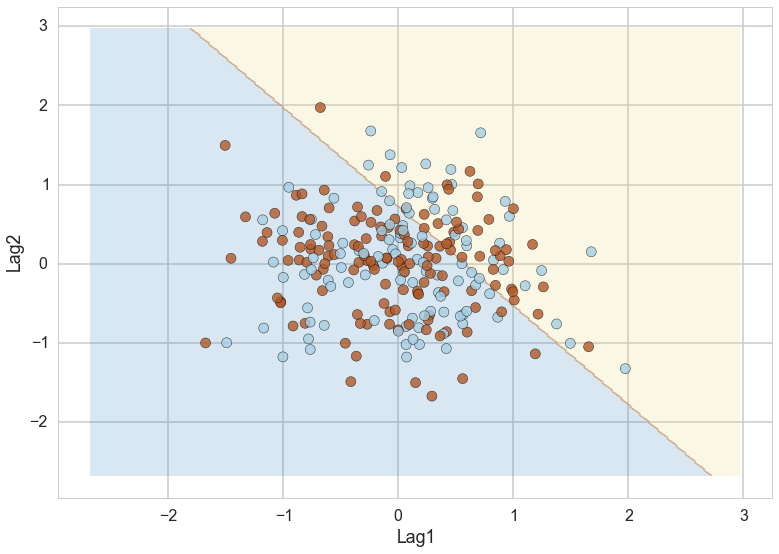

In [65]:
Xtrain = sm_train_df.ix[:,1:3]
Xtest = sm_test_df.ix[:,1:3]
clf3 = LogisticRegression()
clf3.fit(Xtrain, ytrain)
ypred = clf3.predict(Xtest)
# calculate confusion matrix
print (confusion_matrix(ytest, ypred))
# calculate accuracy
print (accuracy_score(ytest, ypred))

plot_decision_boundry(Xtest, ytest, clf3)

### Linear Disriminant Analysis

[[ 76  35]
 [106  35]]
0.440476190476


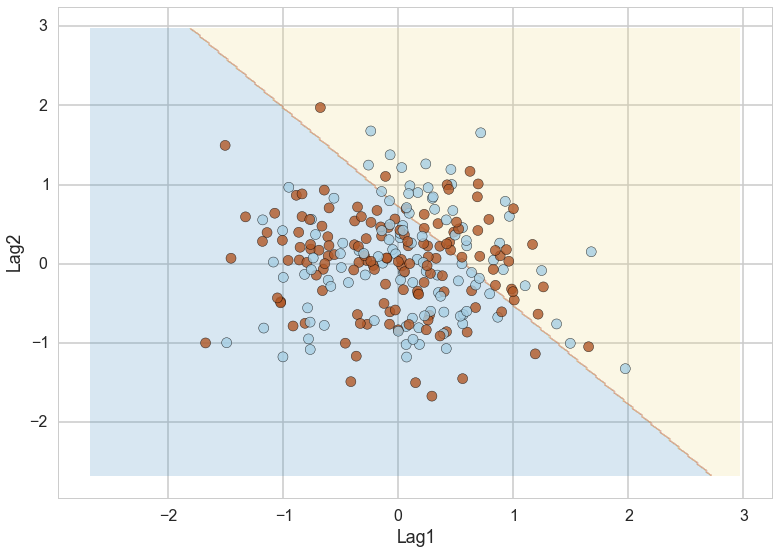

In [66]:
clf4 = LDA()
clf4.fit(Xtrain, ytrain)
ypred = clf4.predict(Xtest)
# calculate confusion matrix
print (confusion_matrix(ytest, ypred))
# calculate accuracy
print (accuracy_score(ytest, ypred))

plot_decision_boundry(Xtest, ytest, clf4)

### K_Nearest Neighbors

In [60]:
clf5 = KNeighborsClassifier()
clf5.fit(Xtrain, ytrain)
ypred = clf5.predict(Xtest)
# calculate confusion matrix
print (confusion_matrix(ytest, ypred))
# calculate accuracy
print (accuracy_score(ytest, ypred))

[[71 40]
 [82 59]]
0.515873015873
